# Weather Data Clustering

This project analyzes weather data using **unsupervised learning** techniques:  
- **K-Means Clustering**  
- **Gaussian Mixture Models (GMM)**  
- **DBSCAN**  

We will analyze both **hourly records** and **monthly averages** for 2024.


In [8]:
# Importing Libraries
import numpy as np, pandas as pd, seaborn as sns, matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix, accuracy_score
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
import pickle
from tqdm import tqdm

#ignore all warnings
import warnings
warnings.filterwarnings(action= 'ignore')

#set some plot parameters
mpl.rcParams['figure.figsize'] = [16, 9]

In [ ]:
# I wrote the code in Google Colab and for dataset I should have wrote this:
import google.colab
google.colab.drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/weather_2.csv')
df


,city,date,temperature,wind_speed,wind_direction,humidity,precipitation,visibility,surface_pressure,rain,snowfall,cloud_cover,uv_index,weather_code,latitude,longitude,wind_direction_cat,rain_cat,snowfall_cat,cloud_cover_cat
0,Abu Dhabi,2022-07-11 00:00:00,30.92,16.42,127.88,75.0,0.0,24140.0,995.54,0.0,0.0,100.0,0.00,3.0,24.38,54.50,SE,none,none,Overcast
1,Abu Dhabi,2022-07-11 01:00:00,31.02,15.91,127.65,74.0,0.0,24140.0,996.24,0.0,0.0,100.0,0.00,3.0,24.38,54.50,SE,none,none,Overcast
2,Abu Dhabi,2022-07-11 02:00:00,31.62,17.87,124.33,71.0,0.0,24140.0,997.04,0.0,0.0,100.0,0.00,3.0,24.38,54.50,SE,none,none,Overcast
3,Abu Dhabi,2022-07-11 03:00:00,31.72,21.44,139.09,71.0,0.0,24140.0,997.54,0.0,0.0,100.0,0.45,3.0,24.38,54.50,SE,none,none,Overcast
4,Abu Dhabi,2022-07-11 04:00:00,31.72,23.28,148.28,71.0,0.0,24140.0,998.04,0.0,0.0,100.0,1.70,3.0,24.38,54.50,SE,none,none,Overcast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958683,Yamoussoukro,2025-07-11 19:00:00,20.82,3.10,305.54,56.0,0.0,68680.0,998.89,0.0,0.0,97.0,0.05,3.0,45.82,15.98,NW,none,none,Overcast
4958684,Yamoussoukro,2025-07-11 20:00:00,18.52,4.10,15.26,64.0,0.0,59420.0,999.16,0.0,0.0,37.0,0.00,1.0,45.82,15.98,NE,none,none,Partly Cloudy
4958685,Yamoussoukro,2025-07-11 21:00:00,17.47,3.67,348.69,64.0,0.0,59560.0,999.20,0.0,0.0,0.0,0.00,0.0,45.82,15.98,NW,none,none,Clear
4958686,Yamoussoukro,2025-07-11 22:00:00,16.22,3.22,333.44,73.0,0.0,43280.0,999.23,0.0,0.0,0.0,0.00,0.0,45.82,15.98,NW,none,none,Clear


In [4]:
df = pd.read_csv('weather_2.csv')

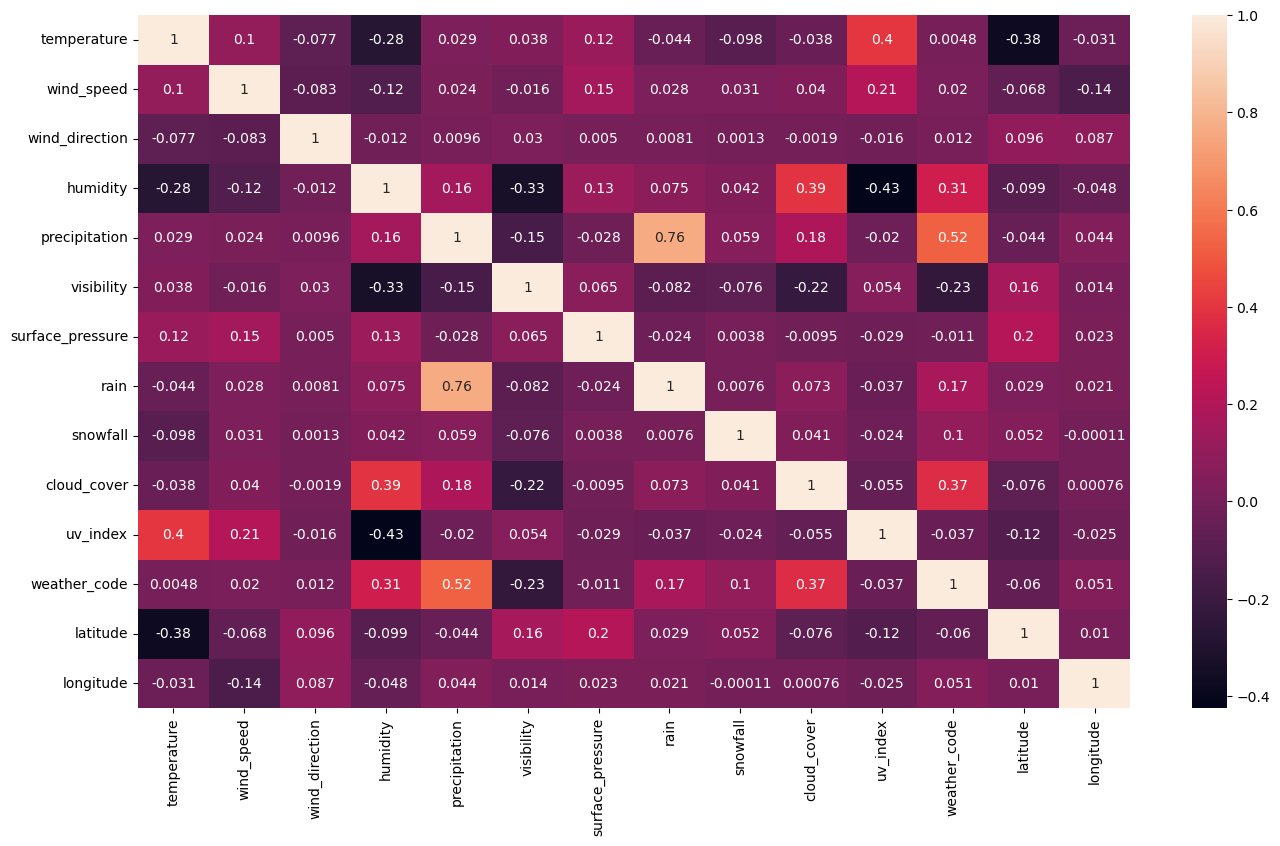

In [5]:
#correlation heatmap for numeric features
sns.heatmap(df.select_dtypes(exclude='object').corr(), annot=True)
plt.show()

In [6]:
#converting 'date' to datetime and removing timezone
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.tz_localize(None)
unique_cities = df['city'].unique()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4958688 entries, 0 to 4958687
Data columns (total 20 columns):
 #   Column              Dtype         
---  ------              -----         
 0   city                object        
 1   date                datetime64[ns]
 2   temperature         float64       
 3   wind_speed          float64       
 4   wind_direction      float64       
 5   humidity            float64       
 6   precipitation       float64       
 7   visibility          float64       
 8   surface_pressure    float64       
 9   rain                float64       
 10  snowfall            float64       
 11  cloud_cover         float64       
 12  uv_index            float64       
 13  weather_code        float64       
 14  latitude            float64       
 15  longitude           float64       
 16  wind_direction_cat  object        
 17  rain_cat            object        
 18  snowfall_cat        object        
 19  cloud_cover_cat     object        
dtypes:

## K-MEANS, GMM and DBSCAN with Selected Hours of year 2024

In [16]:
#Year 2024 at 6:00 and 18:00 hours weather data
selected_hours = [6, 18]
selected_years =  [2024]
df_4hours = df[(df['date'].dt.hour.isin(selected_hours)) & (df['date'].dt.year.isin(selected_years)) ].copy()

In [17]:
#Selecting important columns for clustering
cols = ['temperature', 'wind_speed', 'humidity', 'surface_pressure','precipitation', 'visibility', 'cloud_cover', 'uv_index']
df_with_cols = df_4hours[cols]

In [18]:
#Scaling the dataset using Standard Scaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_with_cols)

### K-Means

In [19]:
#Lists of metric results for each k cluster
inertia = []
silhouette_scores = []
K = range(2, 11) #Setting clusters between 2 and 11

In [20]:
#Trying KMeans with k from 2 to 10 and recording metrics
for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(df_scaled, kmeans.labels_)
    silhouette_scores.append(score)

100%|██████████| 9/9 [38:40<00:00, 257.80s/it]


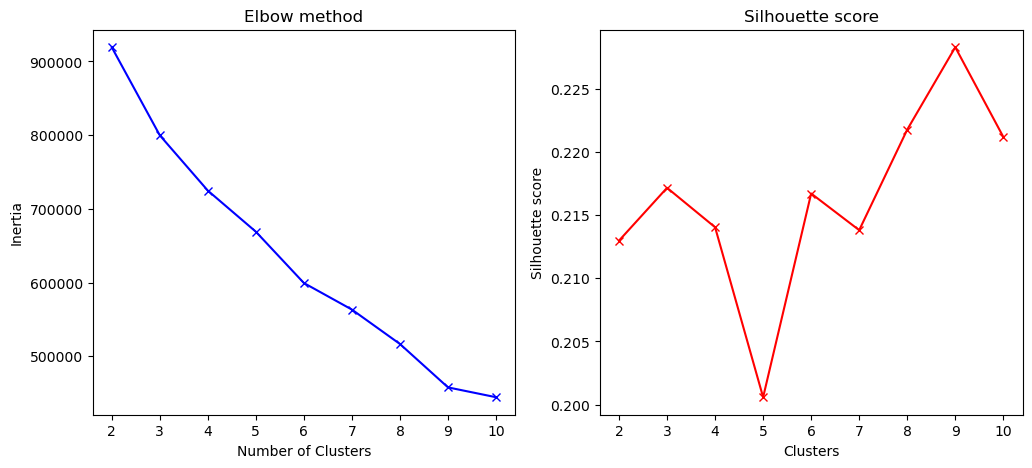

In [48]:
#Plotting Elbow and Silhouette methods to find best k as a subplot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow method')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('Clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score')
plt.show()

In [22]:
# Findinf best k and using that k for final KMeans
optimal_k = K[np.argmax(silhouette_scores)]
print(f"Best amount of clusters: {optimal_k}")

Best amount of clusters: 9


In [23]:
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = final_kmeans.fit_predict(df_scaled)

In [24]:
df_4hours['cluster'] = cluster_labels

### GMM

In [28]:
# Metric list for GMM
silhouette_scores_2 = []

In [32]:
# Trying GMM for same k values
for k in tqdm(K):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(df_scaled)
    silhouette_scores_2.append(silhouette_score(df_scaled, gmm_labels))

100%|██████████| 9/9 [35:56<00:00, 239.60s/it]


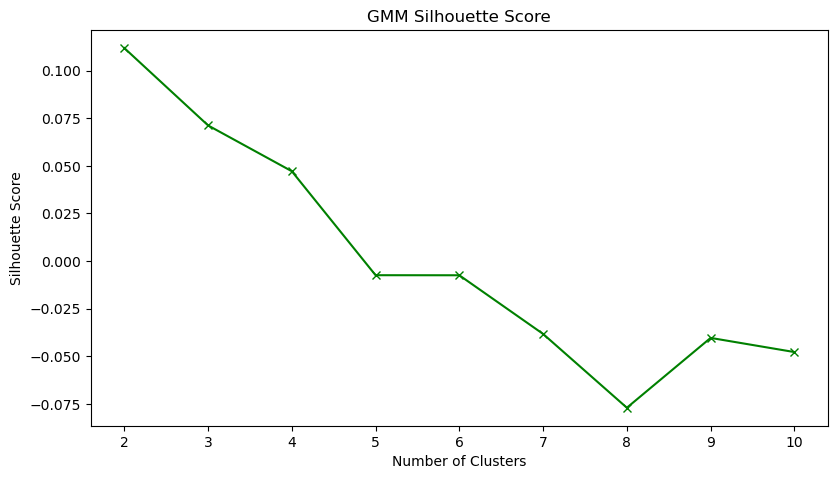

In [34]:
#Plotting Silhouette method to find best k
plt.subplot(2, 2, 3)
plt.plot(K, silhouette_scores_2, 'gx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('GMM Silhouette Score')
plt.tight_layout()
plt.show()

In [36]:
# Using best k for final GMM
final_gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = final_gmm.fit_predict(df_scaled)

In [37]:
df_4hours['gmm_cluster'] = gmm_labels

In [38]:
# Saving models using pickle for deploying later to Streamlit
with open('kmeans_model_4hours.pkl', 'wb') as f:
    pickle.dump(final_kmeans, f)
with open('gmm_model_4hours.pkl', 'wb') as f:
    pickle.dump(final_gmm, f)
with open('scaler_4hours.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [41]:
df_4hours

,city,date,temperature,wind_speed,wind_direction,humidity,precipitation,visibility,surface_pressure,rain,...,uv_index,weather_code,latitude,longitude,wind_direction_cat,rain_cat,snowfall_cat,cloud_cover_cat,cluster,gmm_cluster
1655574,Abu Dhabi,2024-01-01 06:00:00,23.95,10.46,319.19,71.0,0.0,24140.0,1019.21,0.0,...,2.50,2.0,24.38,54.50,NW,none,none,Partly Cloudy,1,3
1655586,Abu Dhabi,2024-01-01 18:00:00,22.60,10.18,315.00,77.0,0.0,24140.0,1018.41,0.0,...,0.00,1.0,24.38,54.50,NW,none,none,Partly Cloudy,0,1
1655598,Abu Dhabi,2024-01-02 06:00:00,24.05,16.06,312.27,66.0,0.0,24140.0,1019.11,0.0,...,2.45,2.0,24.38,54.50,NW,none,none,Partly Cloudy,4,3
1655610,Abu Dhabi,2024-01-02 18:00:00,21.75,6.49,273.18,69.0,0.0,24140.0,1016.51,0.0,...,0.00,2.0,24.38,54.50,N,none,none,Partly Cloudy,0,1
1655622,Abu Dhabi,2024-01-03 06:00:00,20.95,5.86,222.51,74.0,0.0,24140.0,1017.71,0.0,...,2.45,1.0,24.38,54.50,SW,none,none,Partly Cloudy,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4954026,Yamoussoukro,2024-12-29 18:00:00,2.32,1.14,18.44,73.0,0.0,57960.0,1012.48,0.0,...,0.00,0.0,45.82,15.98,NE,none,none,Clear,6,0
4954038,Yamoussoukro,2024-12-30 06:00:00,-3.58,1.48,284.04,100.0,0.0,300.0,1013.58,0.0,...,0.00,45.0,45.82,15.98,NW,none,none,Overcast,5,0
4954050,Yamoussoukro,2024-12-30 18:00:00,2.22,3.98,5.19,79.0,0.0,40020.0,1015.23,0.0,...,0.00,0.0,45.82,15.98,NE,none,none,Clear,0,0
4954062,Yamoussoukro,2024-12-31 06:00:00,-3.58,0.36,180.00,100.0,0.0,140.0,1015.94,0.0,...,0.00,45.0,45.82,15.98,S,none,none,Overcast,5,0


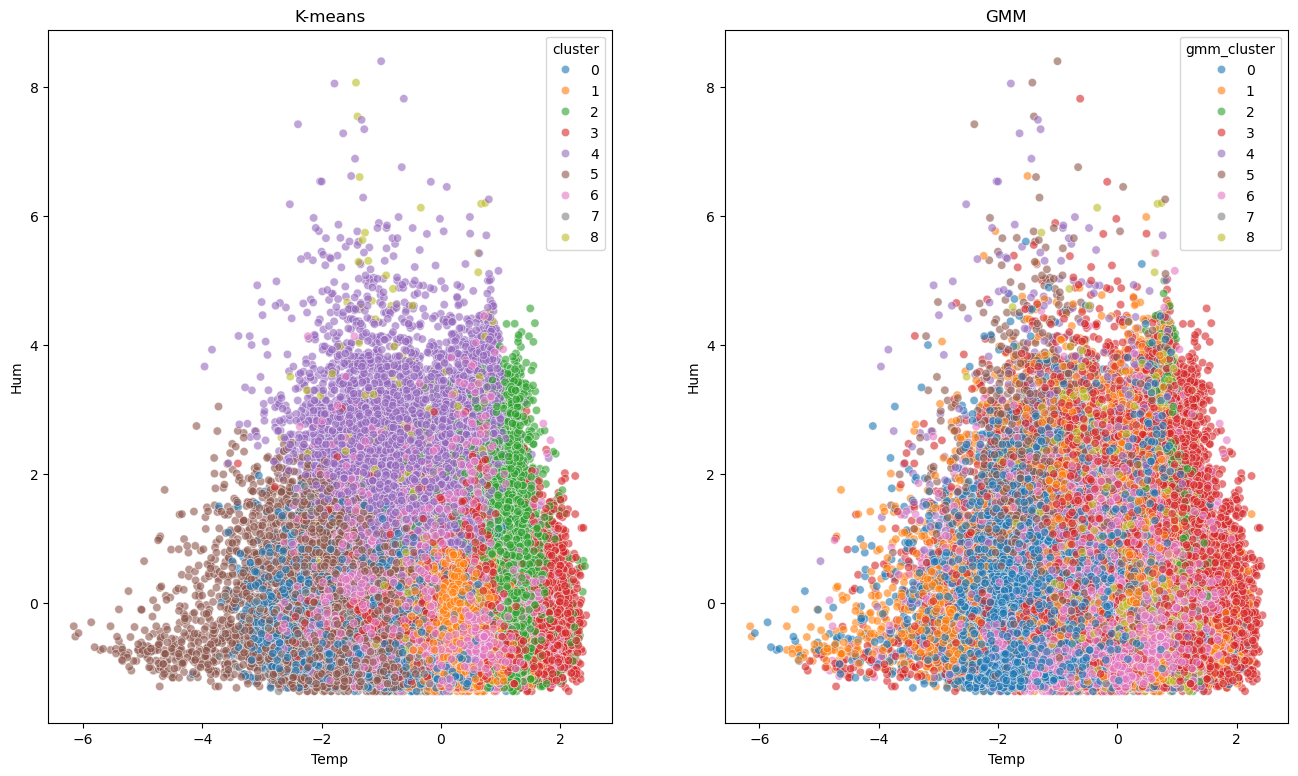

In [47]:
# Scatter plots of clusters from K-Means and GMM
plt.subplot(1, 2, 1)
sns.scatterplot(x=df_scaled[:, 0], y=df_scaled[:, 2], hue=df_4hours['cluster'], palette='tab10')
plt.title('K-means')
plt.xlabel('Temp')
plt.ylabel('Hum')

plt.subplot(1, 2, 2)
sns.scatterplot(x=df_scaled[:, 0], y=df_scaled[:, 2], hue=df_4hours['gmm_cluster'], palette='tab10')
plt.title('GMM')
plt.xlabel('Temp')
plt.ylabel('Hum')
plt.show()

In [52]:
# Evaluation metrics (inertia, DBI, DHI, silhoutte) for both GMM and K-Means
kmeans_labels = df_4hours['cluster']
kmeans_inertia = kmeans.inertia_
kmeans_silhouette = silhouette_score(df_scaled, kmeans_labels) if len(np.unique(kmeans_labels)) > 1 else 0
kmeans_dbi = davies_bouldin_score(df_scaled, kmeans_labels)
kmeans_chi = calinski_harabasz_score(df_scaled, kmeans_labels)

gmm_labels = df_4hours['gmm_cluster']
gmm_silhouette = silhouette_score(df_scaled, gmm_labels) if len(np.unique(gmm_labels)) > 1 else 0
gmm_dbi = davies_bouldin_score(df_scaled, gmm_labels)
gmm_chi = calinski_harabasz_score(df_scaled, gmm_labels)

In [54]:
kmeans_inertia

444543.7324768099

In [55]:
kmeans_silhouette

0.2282773124725693

In [56]:
kmeans_dbi

1.2330525044609577

In [57]:
kmeans_chi

24336.804919774717

In [58]:
gmm_silhouette

-0.04036678883445068

In [59]:
gmm_dbi

4.272214658654109

In [60]:
gmm_chi

3441.664737374612

In [1]:
# For a good clustering silhoutte result should have been more than 0.5
# For a good clustering DBI result should have been less than 1
# For a good clustering CHI result should have been more than 1000

### DBSCAN

In [64]:
# Trying different eps and min_samples for finding the best results
eps_values = [0.3, 0.5, 0.7, 1.0]
min_samples_values = [5, 10, 15] 
dbscan_results = []

In [65]:
# Recording metrics for each value
for eps in tqdm(eps_values):
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(df_scaled)
        
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        
        silhouette = silhouette_score(df_scaled, dbscan_labels)
        dbi = davies_bouldin_score(df_scaled, dbscan_labels)
        chi = calinski_harabasz_score(df_scaled, dbscan_labels)
        
        dbscan_results.append({'eps': eps,'min_samples': min_samples,'n_clusters': n_clusters,'n_noise': n_noise,'silhouette': silhouette,'dbi': dbi,'chi': chi})

100%|██████████| 4/4 [1:04:03<00:00, 960.92s/it]


In [69]:
# Converting results to a dataframe
dbscan_results_df = pd.DataFrame(dbscan_results)
dbscan_results_df

,eps,min_samples,n_clusters,n_noise,silhouette,dbi,chi
0,0.3,5,812,63398,-0.671487,1.315558,24.906424
1,0.3,10,193,82477,-0.591764,1.276866,119.618820
2,0.3,15,100,92532,-0.552199,1.295193,190.000137
3,0.5,5,217,15704,-0.536941,1.297361,63.421876
4,0.5,10,83,24313,-0.438221,1.270234,161.614558
5,0.5,15,55,31120,-0.431711,1.344477,212.846363
6,0.7,5,43,4038,-0.214158,1.273453,259.780192
7,0.7,10,14,6383,0.065661,1.480564,823.008065
8,0.7,15,13,8391,0.124335,1.417509,874.067750
9,1.0,5,9,832,0.108250,1.580298,364.706162


In [70]:
# Choosing best clustering metric
best_dbscan = dbscan_results_df.loc[dbscan_results_df['silhouette'].idxmax()]
best_dbscan

eps               1.000000
min_samples      10.000000
n_clusters        5.000000
n_noise        1275.000000
silhouette        0.350817
dbi               1.394165
chi             785.671652
Name: 10, dtype: float64

In [79]:
# Using best k for final dbscan
optimal_eps = best_dbscan['eps']
optimal_min_samples = int(best_dbscan['min_samples'])
final_dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
dbscan_labels = final_dbscan.fit_predict(df_scaled)

In [80]:
df_4hours['dbscan_cluster'] = dbscan_labels

In [81]:
# Saving the dbscan model
with open('dbscan_model_4hours.pkl', 'wb') as f:
    pickle.dump(final_dbscan, f)

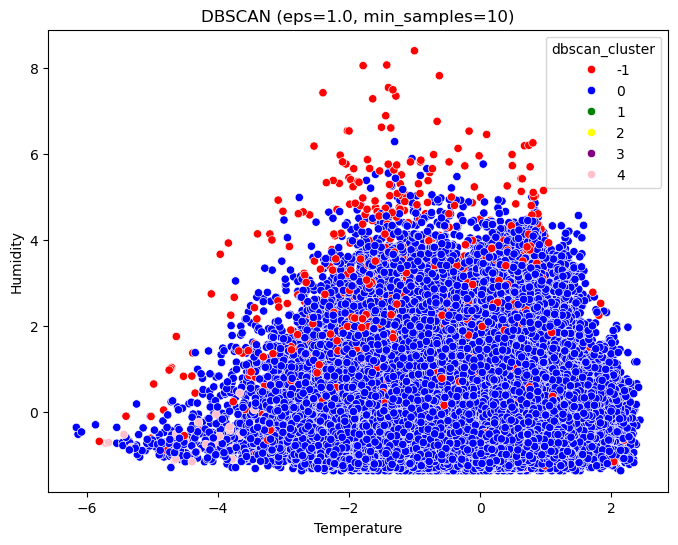

In [89]:
# Scatter plots of clusters from DBSCAN
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_scaled[:, 0], y=df_scaled[:, 1], hue=df_4hours['dbscan_cluster'], palette=['red','blue','green','yellow','purple','pink'])
plt.title(f'DBSCAN (eps={optimal_eps}, min_samples={optimal_min_samples})')
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.show()

## K-Means with selected dates

In [112]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

In [113]:
df_2024 = df[df['year'] == 2024]

In [114]:
numeric_cols = ['temperature', 'wind_speed', 'wind_direction', 'humidity','precipitation', 'visibility', 'surface_pressure','rain', 'snowfall', 'cloud_cover', 'uv_index', 'latitude', 'longitude']
categorical_cols = ['wind_direction_cat', 'rain_cat', 'snowfall_cat', 'cloud_cover_cat']

In [115]:
# Groupping by city and month, computing mean and mode for applying clustering afterwards
grouped = df_2024.groupby(['city', 'month'])
mean_df = grouped[numeric_cols].mean()

In [117]:
mean_df

temperature  wind_speed  wind_direction   humidity  \
city      month                                                       
Abu Dhabi 1        21.856317    9.127151      234.477056  62.006720   
          2        21.701078   13.138477      232.820417  63.801724   
          3        23.997043   11.429288      193.444315  63.528226   
          4        27.413819    9.614722      222.662139  55.969444   
          5        32.281048   10.648495      219.484167  50.603495   
...                      ...         ...             ...        ...   
Yaoundé   8        27.137688   13.027540      117.172500  43.010753   
          9        21.650625   10.025986      123.054972  50.193056   
          10       13.466317    8.010349      125.542849  51.959677   
          11        6.985208    7.605694      121.564403  60.144444   
          12        1.646895    6.472675      120.237527  68.161290   

                 precipitation    visibility  surface_pressure      rain  \
city      month                                                            
Abu Dhabi 1           0.000269  24096.290323       1016.876452  0.000000   
          2           0.028305  23932.068966       1015.947931  0.000431   
          3           0.076210  23708.602151       1013.849745  0.020430   
          4           0.123750  23901.194444       1008.555694  0.002500   
          5           0.019892  24038.279570       1004.857352  0.009812   
...                        ...           ...               ...       ...   
Yaoundé   8           0.009543  73813.494624        900.267231  0.000000   
          9           0.048750  67975.166667        902.738792  0.002083   
          10          0.064382  66500.887097        904.430376  0.029032   
          11          0.048750  61068.194444        905.277806  0.024167   
          12          0.012231  51651.586022        906.689704  0.010349   

                 snowfall  cloud_cover  uv_index  latitude  longitude  
city      month                                                        
Abu Dhabi 1      0.000000    43.408602  1.239583     24.38       54.5  
          2      0.000000    44.386494  1.502443     24.38       54.5  
          3      0.000000    53.081989  1.848858     24.38       54.5  
          4      0.000000    37.355556  2.125278     24.38       54.5  
          5      0.000000     7.081989  2.427688     24.38       54.5  
...                   ...          ...       ...       ...        ...  
Yaoundé   8      0.000000    31.916667  2.377554     40.19       44.5  
          9      0.000000    49.754167  1.813542     40.19       44.5  
          10     0.000000    42.071237  1.176546     40.19       44.5  
          11     0.003597    46.012500  0.757778     40.19       44.5  
          12     0.000188    45.998656  0.578696     40.19       44.5  

[2256 rows x 13 columns]

In [118]:
# Combine mean and mode values for fully dataset
mode_df = grouped[categorical_cols].agg(lambda x: x.mode().iloc[0])
monthly_2024_df = pd.concat([mean_df, mode_df], axis=1).reset_index()
monthly_2024_df.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [121]:
monthly_2024_df

,city,month,temperature,wind_speed,wind_direction,humidity,precipitation,visibility,surface_pressure,rain,snowfall,cloud_cover,uv_index,wind_direction_cat,rain_cat,snowfall_cat,cloud_cover_cat
0,Abu Dhabi,1,21.856317,9.127151,234.477056,62.006720,0.000269,24096.290323,1016.876452,0.000000,0.000000,43.408602,1.239583,NW,none,none,Partly Cloudy
1,Abu Dhabi,2,21.701078,13.138477,232.820417,63.801724,0.028305,23932.068966,1015.947931,0.000431,0.000000,44.386494,1.502443,NW,none,none,Partly Cloudy
2,Abu Dhabi,3,23.997043,11.429288,193.444315,63.528226,0.076210,23708.602151,1013.849745,0.020430,0.000000,53.081989,1.848858,NW,none,none,Overcast
3,Abu Dhabi,4,27.413819,9.614722,222.662139,55.969444,0.123750,23901.194444,1008.555694,0.002500,0.000000,37.355556,2.125278,NW,none,none,Clear
4,Abu Dhabi,5,32.281048,10.648495,219.484167,50.603495,0.019892,24038.279570,1004.857352,0.009812,0.000000,7.081989,2.427688,NW,none,none,Clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251,Yaoundé,8,27.137688,13.027540,117.172500,43.010753,0.009543,73813.494624,900.267231,0.000000,0.000000,31.916667,2.377554,NE,none,none,Clear
2252,Yaoundé,9,21.650625,10.025986,123.054972,50.193056,0.048750,67975.166667,902.738792,0.002083,0.000000,49.754167,1.813542,NE,none,none,Overcast
2253,Yaoundé,10,13.466317,8.010349,125.542849,51.959677,0.064382,66500.887097,904.430376,0.029032,0.000000,42.071237,1.176546,NE,none,none,Clear
2254,Yaoundé,11,6.985208,7.605694,121.564403,60.144444,0.048750,61068.194444,905.277806,0.024167,0.003597,46.012500,0.757778,NE,none,none,Clear


In [122]:
# Encode categorical columns
encoded = pd.get_dummies(monthly_2024_df, columns=categorical_cols)

In [123]:
cols = encoded.drop(['city', 'month'], axis=1)

In [124]:
# Standardize and apply PCA
scaler = StandardScaler()
scaled_df = scaler.fit_transform(cols)

In [150]:
pca = PCA(n_components=3)
scaled_pca = pca.fit_transform(scaled_df)

In [151]:
# Same as before, applying model, plotting the method results
# then with best k clustering the data and plotting the result
inertia_2 = []
silhouette_scores_2 = []
K_2 = range(2, 30)

In [152]:
for k in tqdm(K_2):
    kmeans_2 = KMeans(n_clusters=k, random_state=42)
    kmeans_2.fit(scaled_pca)
    inertia_2.append(kmeans_2.inertia_)
    score_2 = silhouette_score(scaled_pca, kmeans_2.labels_)
    silhouette_scores_2.append(score_2)

100%|██████████| 28/28 [00:02<00:00,  9.58it/s]


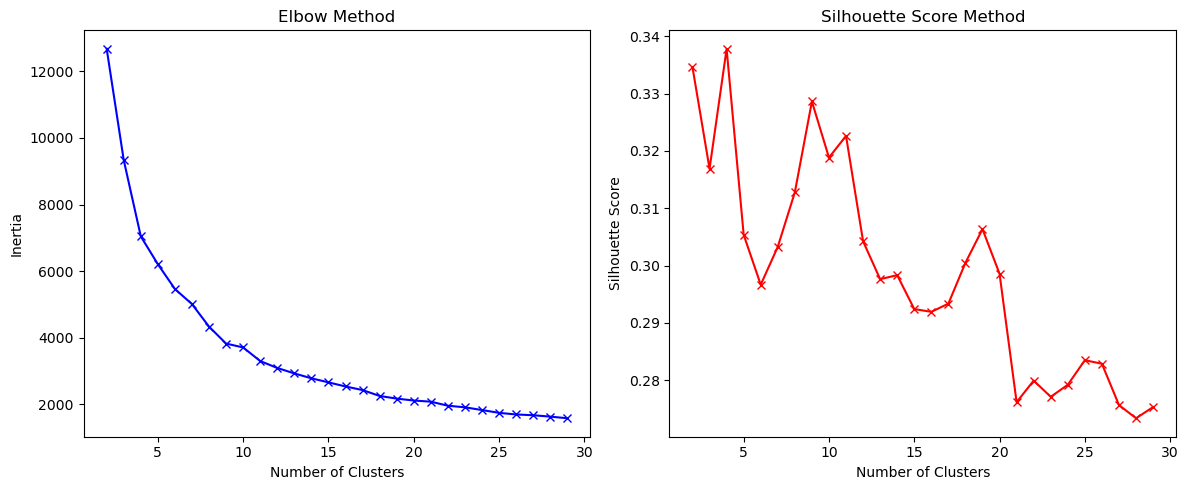

In [153]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_2, inertia_2, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.subplot(1, 2, 2)
plt.plot(K_2, silhouette_scores_2, 'rx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.tight_layout()
plt.show()

In [154]:
optimal_k_2 = K_2[np.argmax(silhouette_scores_2)]
print(f"Best amount of clusters: {optimal_k_2}")

Best amount of clusters: 4


In [155]:
final_kmeans_2 = KMeans(n_clusters=optimal_k_2, random_state=42)
cluster_labels_2 = final_kmeans_2.fit_predict(scaled_df)

In [156]:
monthly_2024_df['cluster'] = cluster_labels_2

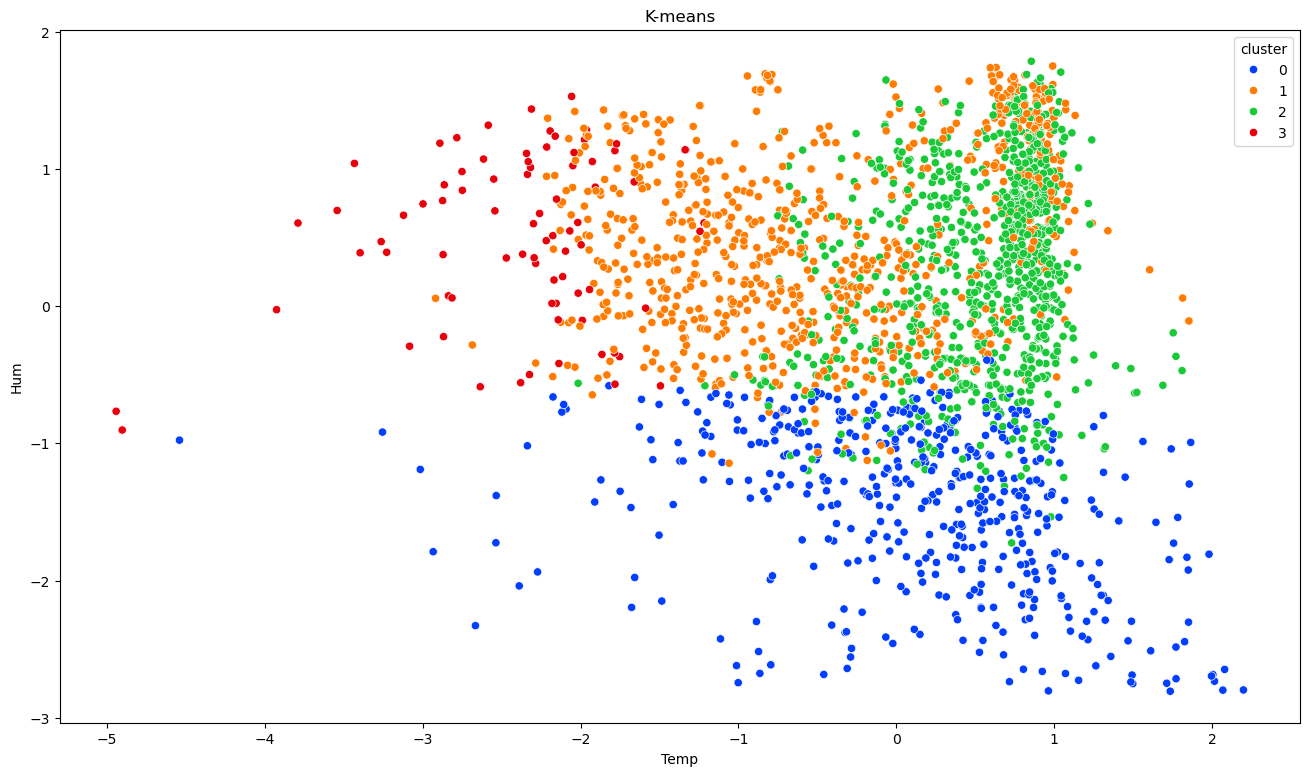

In [162]:
sns.scatterplot(x=scaled_df[:, 0], y=scaled_df[:, 9], hue=monthly_2024_df['cluster'], palette='bright')
plt.title('K-means')
plt.xlabel('Temp')
plt.ylabel('Hum')
plt.show()

In [158]:
# Firstly I applied 4 clusters because of the methods
# then just for visual I groupped them for 7 clusters
final_kmeans_2_2 = KMeans(n_clusters=7, random_state=42)
cluster_labels_2_2 = final_kmeans_2_2.fit_predict(scaled_df)

In [159]:
monthly_2024_df['cluster_minimalized'] = cluster_labels_2_2

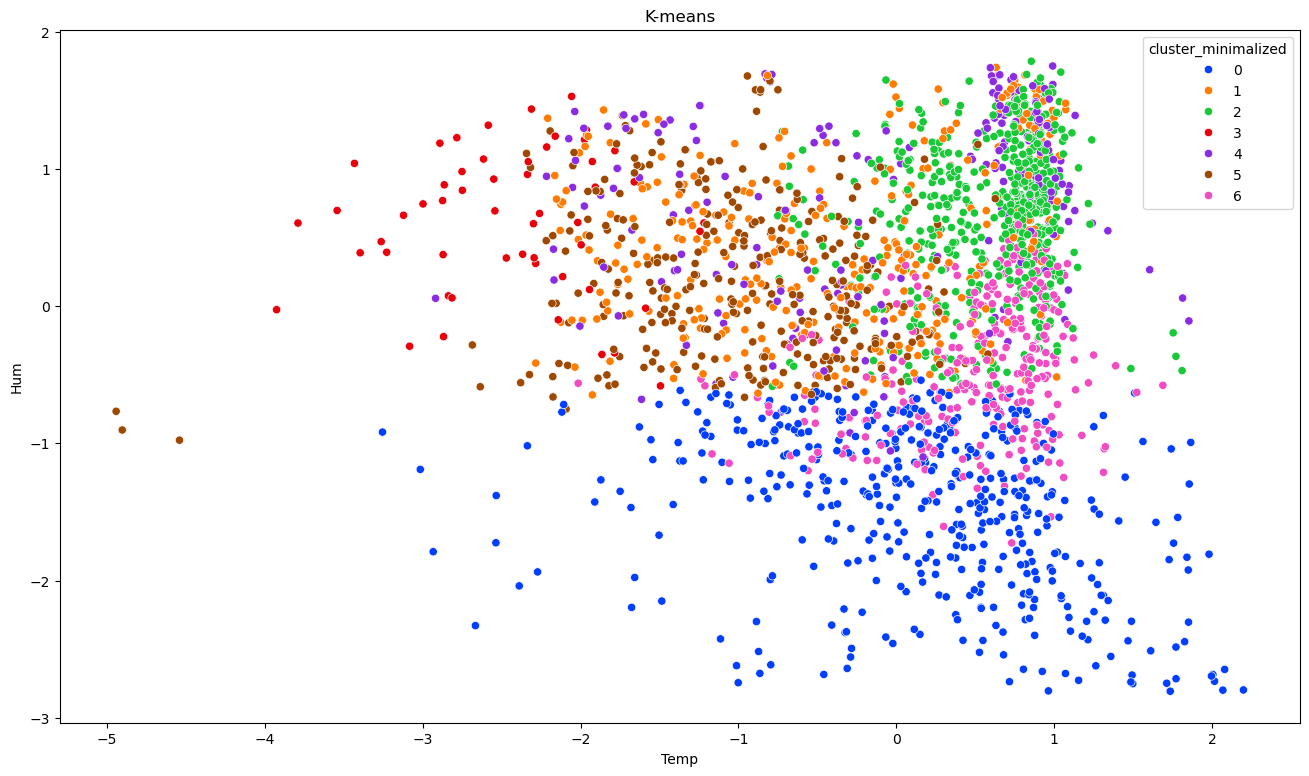

In [160]:
sns.scatterplot(x=scaled_df[:, 0], y=scaled_df[:, 9], hue=monthly_2024_df['cluster_minimalized'], palette='bright')
plt.title('K-means')
plt.xlabel('Temp')
plt.ylabel('Hum')
plt.show()

In [163]:
# Saving the model, pca and scaler as pickle to deploy later
with open('kmeans_model_monthly_2024_df.pkl', 'wb') as f:
    pickle.dump({'scaler': scaler, 'pca': pca_model, 'kmeans': final_kmeans}, f)